In [1]:
!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
from google.colab import files
files.upload() # upload kaggle.json file
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

[07/23/23 14:16:33] WARNING  Unable to load torch and dependent libraries from                ]8;id=560664;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py\loader.py]8;;\:]8;id=35586;file:///usr/local/lib/python3.10/dist-packages/torch_snippets/loader.py#<module>:98\<module>:98]8;;\
                             torch-snippets.                                                                       
                             Functionalities might be limited. pip install lovely-tensors in                       
                             case there are torch related errors                                                   

Saving kaggle.json to kaggle.json
kaggle.json
 98% 361M/367M [00:03<00:00, 125MB/s]
100% 367M/367M [00:03<00:00, 117MB/s]


In [2]:
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# PREPARING THE DATASET
import pandas as pd

# images path
IMAGE_ROOT = 'images/images'

# ground truths present in the csv file
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head(10))

ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   
5  0002914fa805e227  xclick     Truck           1  0.061250  0.966875   
6  00036603fa39fa85  xclick     Truck           1  0.058125  0.983125   
7  0004d5a9dd44ab6a  xclick     Truck           1  0.035625  0.188125   
8  0004d5a9dd44ab6a  xclick     Truck           1  0.094375  0.897500   
9  0004d5a9dd44ab6a  xclick     Truck           1  0.860625  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   
5  0.125399  0.974495           1            0  ...            1         0   
6  0.053333  0.940000           0            0  ...            0         0   
7  0.189893  0.320827           0            0  ...            0         0   
8  0.147014  0.934150           0            0  ...            0         0   
9  0.249617  0.390505           1            0  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.343750  0.795000  0.908750  0.156162  0.512700  0.650047   
1  0.299167  0.276667  0.697500  0.659167  0.141604  0.241855  0.352130   
2  0.849167  0.702500  0.906667  0.999167  0.204261  0.398496  0.409774   
3  0.274375  0.371250  0.311875  0.156250  0.269188  0.493882  0.705228   
4  0.920000  0.999375  0.648750  0.287500  0.194184  0.303940  0.999062   
5  0.756875  0.966875  0.501875  0.061250  0.974495  0.598300  0.125399   
6  0.058125  0.598750  0.983125  0.710000  0.550000  0.053333  0.337778   
7  0.115000  0.035625  0.139375  0.188125  0.189893  0.245023  0.320827   
8  0.365000  0.094375  0.333750  0.897500  0.147014  0.609495  0.934150   
9  0.992500  0.999375  0.860625  0.921250  0.249617  0.294028  0.325421   

   XClick4Y  
0  0.457197  
1  0.437343  
2  0.295739  
3  0.521691  
4  0.523452  
5  0.382572  
6  0.940000  
7  0.236600  
8  0.822358  
9  0.390505  

[10 rows x 21 columns]

In [4]:
import cv2
import numpy as np

# Define a class which return an image, its correspondind class and groud truth
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()       # return an array of image filenames (no dataframe indexes)

    def __len__(self):
        return len(self.unique_images)

    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = self.root + '/' + image_id + '.jpg'
        image = cv2.imread(image_path)[...,::-1] # convert BGR to RGB
        h, w, _ = image.shape

        df = self.df.copy()
        df = df[df['ImageID'] == image_id]

        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes*np.array([w, h, w, h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path


In [5]:
ds = OpenImages(df=DF_RAW)

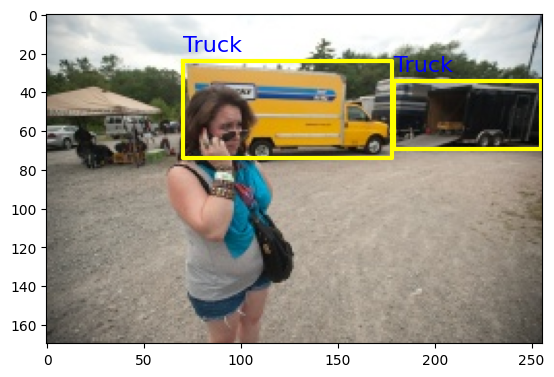

In [6]:
im, bbs, clss, _ = ds[1]

import matplotlib.pyplot as plt
plt.imshow(im)
for i in range(len(bbs)):
    xs = [bbs[i][0], bbs[i][2], bbs[i][2], bbs[i][0], bbs[i][0]]
    ys = [bbs[i][1], bbs[i][1], bbs[i][-1], bbs[i][-1], bbs[i][1]]
    plt.plot(xs, ys, c = 'yellow', lw = 3)

    plt.text(bbs[i][0], bbs[i][1]-5, clss[i], fontsize = 16, c = 'blue')

In [7]:
print('The ground truth bounding boxes coordinates \n', bbs)

The ground truth bounding boxes coordinates 

[[70, 24, 178, 74], [179, 34, 255, 69]]

In [8]:
# define a function to fetch the regions proposal from an image
def extract_candidates(image):
    img_lbl, regions = selectivesearch.selective_search(image, scale = 200, min_size=100)

    # fetch only regions that are over 5% of image area or below 100% of the
    # image area
    image_area = image.shape[0]*image.shape[1]

    candidates = []
    for r in regions:
        if r['rect'] in candidates:continue
        if r['size'] < 0.05*image_area:continue
        if r['size'] > 1*image_area:continue

        # xmin, ymin, xmax, ymax region coordinates are extracted from the region
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [9]:
# epsilon is there to avoid division by zero
def get_iou(boxA, boxB, epsilon = 1e-5):

    # Overlapping regions
    # corners points
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])

    # compute the area of the overlapping area
    width = (x2 - x1)
    height = (y2 - y1)
    if (width < 0) or (height < 0):
        # return iou = 0.0, if the overlap area is zero
        return 0.0
    area_overlap = width*height

    # combined area
    area_a = (boxA[2] - boxA[0])*(boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0])*(boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap

    iou = area_overlap/(area_combined + epsilon)
    return iou

In [10]:
# Assigned a class to each region proposal and also created the other
# ground truth of the bounding box offset

# treshold
treshold_value = 0.3

# Initialized empty lists
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

# We will work on N images for this example
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape

    # extract the regions proposal and convert their coordinates system
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])

    # Initialize ious, rois, deltas, and clss as lists that store iou for each
    # candidate, region proposal location, bounding box offset, and class
    # corresponding to every candidate for each image
    ious, rois, clss, deltas = [], [], [], []
    ious = np.array([[get_iou(candidate, _bb_) for candidate in candidates] for _bb_ in bbs]).T

    # loop over the candidates and extract the coordinates XMin(cx), YMin(cy), XMax(cX) and YMax(cY)
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate

        # Extract the candidate ious with respect to all the ground truth
        # bounding boxes of the objects present in the image
        candidate_ious = ious[jx]

        # Find the index of a candidate (best_iou_at) that has the highest IoU
        # and the corresponding ground truth (best_bb)

        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]

        # If IoU (best_iou) is greater than a threshold (0.3), we assign the label
        # of class corresponding to the candidate, and the background otherwise
        if best_iou > treshold_value: clss.append(labels[best_iou_at])
        else : clss.append('background')

        # how much should the
        # left, right, top, and bottom margins of the current proposal be adjusted
        # so that it aligns exactly with best_bb from the ground truth
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

    # Append the file paths, IoU, roi, class delta, and
    # ground truth bounding boxes corresponding to each image
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)

# Fetch the image path names and store all the information
# obtained, FPATHS, IOUS, ROIS, CLSS, DELTAS, and GTBBS, in a list of lists
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]

In [11]:
# Assign indices to each class
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
print("The class's indices are : \n", label2target)

# From target to label
target2label = {t:l for l,t in label2target.items()}

The class's indices are : 

{'Bus': 0, 'background': 1, 'Truck': 2}

In [12]:
# function to normalize an image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# preprocess the image
def preprocess_image(img):
    img = torch.tensor(img).permute(2, 0, 1)
    img = normalize(img)
    return img.to(device).float()

# decode the predictions
def decode(_y):
    _, preds = _y.max(-1)
    return preds

# define a dataset (RCNNDataset) with the preprocessed regions proposal and their ground truth
class RCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas

    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        H, W, _ = image.shape
        sh = np.array([W,H,W,H])
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        bbs = (np.array(rois)*sh).astype(np.uint16)
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        crops = [image[y:Y,x:X] for (x,y,X,Y) in bbs]
        return image, crops, bbs, labels, deltas, gtbbs, fpath

    # performs the resizing and normalizing (preprocess_image)
    # of an image of a crop
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, crops, image_bbs, image_labels, image_deltas, image_gt_bbs, image_fpath = batch[ix]
            crops = [cv2.resize(crop, (224,224)) for crop in crops]
            crops = [preprocess_image(crop/255.)[None] for crop in crops]
            input.extend(crops)
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, labels, deltas

In [13]:
n_train = 9*len(FPATHS)//10
train_ds = RCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train], DELTAS[:n_train], GTBBS[:n_train])
test_ds = RCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], DELTAS[n_train:], GTBBS[n_train:])

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(train_ds, batch_size=2, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn, drop_last=True)

In [14]:
# Define a VGG backbone:
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False

vgg_backbone.eval().to(device)
from torchsummary import summary
summary(vgg_backbone, (3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 111MB/s] 


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [15]:
class RCNN(nn.Module):
    def __init__(self):
        super().__init__()
        feature_dim = 25088   # 512*7*7
        self.backbone = vgg_backbone
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )

        # Define the loss functions corresponding to class prediction
        # (self.cel) and bounding box offset regression (self.sl1)
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    def forward(self, input):
        feat = self.backbone(input)
        cls_score = self.cls_score(feat)
        bbox = self.bbox(feat)
        return cls_score, bbox

    def calc_loss(self, probs, _deltas, labels, deltas):
        detection_loss = self.cel(probs, labels)

        # Note that we don't calculate the loss if the label
        # is "background"
        ixs, = torch.where(labels != 1)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

In [16]:
def train_batch(inputs, model, optimizer, criterion):
    input, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _, _clss = _clss.max(-1)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [17]:
rcnn = RCNN().to(device)
criterion = rcnn.calc_loss
optimizer = optim.SGD(rcnn.parameters(), lr=1e-3)
n_epochs = 5
log = Report(n_epochs)

<ipython-input-12-cbb9f14ec236>:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  deltas = torch.Tensor(deltas).float().to(device)


EPOCH: 5.000  val_loss: 1.521  val_loc_loss: 0.546  val_regr_loss: 0.098  val_acc: 0.753  (992.60s - 0.00s remaining)

100%|██████████| 106/106 [00:00<00:00, 3884.23it/s]


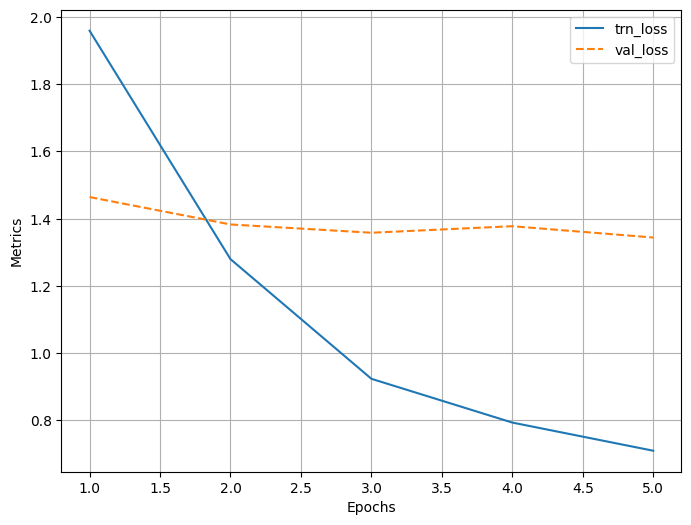

In [18]:
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, rcnn,
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss,
                   trn_regr_loss=regr_loss,
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs,
                                                rcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss,
                val_regr_loss=regr_loss,
                val_acc=accs.mean(), end='\r')

# Plotting training and validation metrics
log.plot_epochs('trn_loss,val_loss'.split(','))

In [30]:
background_class = 1
def test_predictions(filename, show_output=True):
    img = np.array(cv2.imread(filename, 1)[...,::-1])
    candidates = extract_candidates(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = []
    for candidate in candidates:
        x,y,X,Y = candidate
        crop = cv2.resize(img[y:Y,x:X], (224,224))
        input.append(preprocess_image(crop/255.)[None])
    input = torch.cat(input).to(device)
    with torch.no_grad():
        rcnn.eval()
        probs, deltas = rcnn(input)
        probs = torch.nn.functional.softmax(probs, -1)
        confs, clss = torch.max(probs, -1)
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]

    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = (candidates + deltas).astype(np.uint16)
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(confs) == 0 and not show_output:
        return (0,0,224,224), 'background', 1
    if len(confs) > 0:
        best_pred = np.argmax(confs)
        best_conf = np.max(confs)
        best_bb = bbs[best_pred]
        x,y,X,Y = best_bb
    _, ax = plt.subplots(1, 2, figsize=(18, 8))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title('Original image')
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    ax[1].set_title(target2label[clss[best_pred]])
    show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1], title='predicted bounding box and class')
    plt.show()
    return (x,y,X,Y),target2label[clss[best_pred]], best_conf

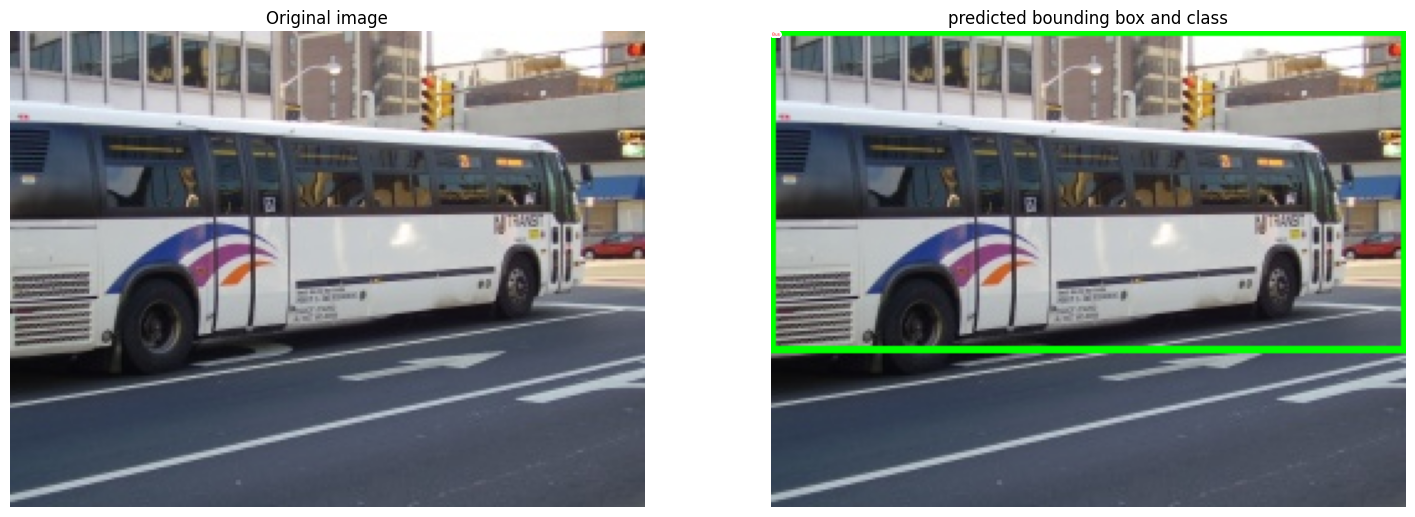

((0, 0, 255, 128), 'Bus', 0.99996996)

In [32]:
image, crops, bbs, labels, deltas, gtbbs, fpath = test_ds[2]
test_predictions(fpath)